In [8]:
%pip install nibabel


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [9]:
%pip install open3d


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [10]:
import os
import glob
import json
import random
import numpy as np
import torch
import torch.nn as nn
import nibabel as nib
import SimpleITK as sitk
from PIL import Image
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from scipy import ndimage
from skimage import measure, morphology
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import trimesh
import open3d as o3d


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [11]:
"PREPROCESSING OF DATATSET"
def inspect_volume(nifti_path):
    """Prints file info: voxel size, spacing, dtype, intensity range, etc."""
    img = sitk.ReadImage(nifti_path)
    arr = sitk.GetArrayFromImage(img)
    print(f"File: {nifti_path}")
    print(f"  Size (voxels):   {img.GetSize()} (X, Y, Z)")
    print(f"  Spacing (mm):    {img.GetSpacing()} (X, Y, Z)")
    print(f"  Data type:       {arr.dtype}")
    print(f"  Intensity range: [{arr.min()}, {arr.max()}]")
    print(f"  Num slices (Z):  {arr.shape[0]}")
    print(f"  Slice shape:     {arr.shape[1]} × {arr.shape[2]}")
    if "labelsTr" in nifti_path or "labelsTs" in nifti_path:
        print(f"  Unique label values: {np.unique(arr)}")


In [12]:
## Cell 2: Preprocessing Volume
def preprocess_volume(input_path, output_path, new_spacing=(0.5,0.5,0.5)):
    img = sitk.ReadImage(input_path)
    original_size = np.array(img.GetSize(), dtype=int)
    original_spacing = np.array(img.GetSpacing())
    new_size = np.round(original_size * (original_spacing / new_spacing)).astype(int)

    resampler = sitk.ResampleImageFilter()
    resampler.SetOutputSpacing(new_spacing)
    resampler.SetSize([int(s) for s in new_size])
    resampler.SetInterpolator(sitk.sitkLinear)
    img_resampled = resampler.Execute(img)

    img_denoised = sitk.CurvatureFlow(image1=img_resampled,
                                       timeStep=0.125,
                                       numberOfIterations=5)

    arr = sitk.GetArrayFromImage(img_denoised).astype(np.float32)
    arr = (arr - arr.mean()) / arr.std()
    img_norm = sitk.GetImageFromArray(arr)
    img_norm.CopyInformation(img_denoised)
    sitk.WriteImage(img_norm, output_path)
    return output_path


In [13]:
def normalize_ct(arr, hu_min=-100, hu_max=400):
    """Clips CT array to [hu_min, hu_max] and scales to [0,1]."""
    arr = np.clip(arr, hu_min, hu_max)
    arr = (arr - hu_min) / (hu_max - hu_min)
    return arr.astype(np.float32)


In [14]:
def resample_to_isotropic(itk_image, new_spacing=(1.0,1.0,1.0)):
    """Resamples an SITK image to isotropic spacing (default 1×1×1 mm)."""
    orig_spacing = itk_image.GetSpacing()
    orig_size = itk_image.GetSize()
    new_size = [
        int(round(orig_size[i] * (orig_spacing[i] / new_spacing[i])))
        for i in range(3)
    ]
    resampler = sitk.ResampleImageFilter()
    resampler.SetOutputSpacing(new_spacing)
    resampler.SetSize(new_size)
    resampler.SetOutputDirection(itk_image.GetDirection())
    resampler.SetOutputOrigin(itk_image.GetOrigin())
    resampler.SetInterpolator(sitk.sitkLinear)
    return resampler.Execute(itk_image)


In [15]:
def process_ct(input_nifti, output_nifti, do_resample=False):
    """
    1) Read a CT volume.
    2) (Optional) Resample to 1×1×1 mm.
    3) Clip intensities to [–100,400] HU and scale to [0,1].
    4) Save result as a new NIfTI.
    """
    img = sitk.ReadImage(input_nifti)
    if do_resample:
        img = resample_to_isotropic(img, new_spacing=(1.0,1.0,1.0))
    arr = sitk.GetArrayFromImage(img).astype(np.float32)
    arr_norm = normalize_ct(arr)
    img_norm = sitk.GetImageFromArray(arr_norm)
    img_norm.CopyInformation(img)
    os.makedirs(os.path.dirname(output_nifti), exist_ok=True)
    sitk.WriteImage(img_norm, output_nifti)
    print(f"[CT] Saved normalized: {output_nifti}")


In [16]:
def resample_mask(input_nifti, output_nifti, do_resample=False):
    """
    1) Read a label mask volume.
    2) (Optional) Resample to 1×1×1 mm using nearest-neighbor interpolation.
    3) Save result as a new NIfTI.
    """
    img = sitk.ReadImage(input_nifti)
    if do_resample:
        orig_spacing = img.GetSpacing()
        orig_size = img.GetSize()
        new_spacing = (1.0,1.0,1.0)
        new_size = [
            int(round(orig_size[i] * (orig_spacing[i] / new_spacing[i])))
            for i in range(3)
        ]
        resampler = sitk.ResampleImageFilter()
        resampler.SetOutputSpacing(new_spacing)
        resampler.SetSize(new_size)
        resampler.SetOutputDirection(img.GetDirection())
        resampler.SetOutputOrigin(img.GetOrigin())
        resampler.SetInterpolator(sitk.sitkNearestNeighbor)
        img = resampler.Execute(img)
    os.makedirs(os.path.dirname(output_nifti), exist_ok=True)
    sitk.WriteImage(img, output_nifti)
    print(f"[Mask] Saved resampled: {output_nifti}")


In [17]:
# Inspect volume
inspect_volume("data_preprocessed/Task02_Heart/imagesTr/la_003.nii.gz")

# Normalize CT without resampling
process_ct("data_preprocessed/Task02_Heart/imagesTr/la_003.nii.gz",
           "data_preprocessed/Task02_Heart/imagesTr_norm/la_003_norm.nii.gz",
           do_resample=False)

# Normalize CT with resampling
process_ct("data_preprocessed/Task02_Heart/imagesTr/la_003.nii.gz",
           "data_preprocessed/Task02_Heart/imagesTr_norm/la_003_resampled.nii.gz",
           do_resample=True)

# Resample a mask
resample_mask("data_preprocessed/Task02_Heart/labelsTr/la_003.nii.gz",
              "data_preprocessed/Task02_Heart/labelsTr_resampled/la_003.nii.gz",
              do_resample=True)

File: data_preprocessed/Task02_Heart/imagesTr/la_003.nii.gz
  Size (voxels):   (320, 320, 130) (X, Y, Z)
  Spacing (mm):    (1.25, 1.25, 1.3700000047683716) (X, Y, Z)
  Data type:       float32
  Intensity range: [0.0, 1999.0]
  Num slices (Z):  130
  Slice shape:     320 × 320
[CT] Saved normalized: data_preprocessed/Task02_Heart/imagesTr_norm/la_003_norm.nii.gz
[CT] Saved normalized: data_preprocessed/Task02_Heart/imagesTr_norm/la_003_resampled.nii.gz
[Mask] Saved resampled: data_preprocessed/Task02_Heart/labelsTr_resampled/la_003.nii.gz


In [18]:
# Create normalized + resampled CT volume
process_ct(
    "data_preprocessed/Task02_Heart/imagesTr/la_003.nii.gz",
    "data_preprocessed/Task02_Heart/imagesTr_norm_resampled/la_003_norm_resampled.nii.gz",
    do_resample=True
)


[CT] Saved normalized: data_preprocessed/Task02_Heart/imagesTr_norm_resampled/la_003_norm_resampled.nii.gz


In [19]:
inspect_volume("data_preprocessed/Task02_Heart/imagesTr_norm_resampled/la_003_norm_resampled.nii.gz")


File: data_preprocessed/Task02_Heart/imagesTr_norm_resampled/la_003_norm_resampled.nii.gz
  Size (voxels):   (400, 400, 178) (X, Y, Z)
  Spacing (mm):    (1.0, 1.0, 1.0) (X, Y, Z)
  Data type:       float32
  Intensity range: [0.20000000298023224, 1.0]
  Num slices (Z):  178
  Slice shape:     400 × 400


In [20]:
import glob

input_dir = "data_preprocessed/Task02_Heart/imagesTr"
out_norm_dir = "data_preprocessed/Task02_Heart/imagesTr_norm_resampled"
os.makedirs(out_norm_dir, exist_ok=True)

for ct_path in glob.glob(f"{input_dir}/*.nii.gz"):
    filename = os.path.basename(ct_path)
    out_path  = os.path.join(out_norm_dir, filename.replace(".nii.gz", "_norm_resampled.nii.gz"))
    process_ct(ct_path, out_path, do_resample=True)


[CT] Saved normalized: data_preprocessed/Task02_Heart/imagesTr_norm_resampled\la_007_norm_resampled.nii.gz
[CT] Saved normalized: data_preprocessed/Task02_Heart/imagesTr_norm_resampled\la_019_norm_resampled.nii.gz
[CT] Saved normalized: data_preprocessed/Task02_Heart/imagesTr_norm_resampled\la_023_norm_resampled.nii.gz
[CT] Saved normalized: data_preprocessed/Task02_Heart/imagesTr_norm_resampled\la_005_norm_resampled.nii.gz
[CT] Saved normalized: data_preprocessed/Task02_Heart/imagesTr_norm_resampled\la_009_norm_resampled.nii.gz
[CT] Saved normalized: data_preprocessed/Task02_Heart/imagesTr_norm_resampled\la_017_norm_resampled.nii.gz
[CT] Saved normalized: data_preprocessed/Task02_Heart/imagesTr_norm_resampled\la_021_norm_resampled.nii.gz
[CT] Saved normalized: data_preprocessed/Task02_Heart/imagesTr_norm_resampled\la_029_norm_resampled.nii.gz
[CT] Saved normalized: data_preprocessed/Task02_Heart/imagesTr_norm_resampled\la_003_norm_resampled.nii.gz
[CT] Saved normalized: data_preproces

In [21]:
"SPLITING OF DATASET" 
import json
import os
import random

def create_splits(task_folder, val_ratio=0.20, seed=42):
    """
    Reads dataset.json in <task_folder>, shuffles the training entries,
    then writes train_list.txt & val_list.txt under <task_folder>.

    Each line in train_list.txt / val_list.txt is:
      <path_to_normed_CT.nii.gz> <path_to_label.nii.gz>
    """
    ds_json = os.path.join(task_folder, "dataset.json")
    
    # Load dataset.json
    with open(ds_json, "r") as f:
        ds = json.load(f)

    # Get training list and shuffle
    train_entries = ds["training"]
    random.seed(seed)
    random.shuffle(train_entries)

    # Split into train and val
    num_total = len(train_entries)
    num_val = int(num_total * val_ratio)
    train_split = train_entries[num_val:]
    val_split = train_entries[:num_val]

    # Output paths
    train_txt = os.path.join(task_folder, "train_list.txt")
    val_txt = os.path.join(task_folder, "val_list.txt")
    test_txt = os.path.join(task_folder, "test_list.txt")

    # Write train list
    with open(train_txt, "w") as ft:
        for entry in train_split:
            img_p = entry["image"]
            img_norm = os.path.join(
                task_folder,
                "imagesTr_norm",
                os.path.basename(img_p).replace(".nii.gz", "_norm.nii.gz")
            )
            lbl_p = os.path.join(task_folder, entry["label"])
            ft.write(f"{img_norm} {lbl_p}\n")

    # Write val list
    with open(val_txt, "w") as fv:
        for entry in val_split:
            img_p = entry["image"]
            img_norm = os.path.join(
                task_folder,
                "imagesTr_norm",
                os.path.basename(img_p).replace(".nii.gz", "_norm.nii.gz")
            )
            lbl_p = os.path.join(task_folder, entry["label"])
            fv.write(f"{img_norm} {lbl_p}\n")

    # Write test list
    with open(test_txt, "w") as ftst:
        for test_img in ds["test"]:
            abs_path = os.path.join(task_folder, test_img[2:])  # remove "./"
            ftst.write(f"{abs_path}\n")

    print(f"Wrote {len(train_split)} pairs to {train_txt}")
    print(f"Wrote {len(val_split)} pairs to {val_txt}")
    print(f"Wrote {len(ds['test'])} lines to {test_txt}")


# Call function directly with your folder
task_folder = r"E:\3D_Organs\data_preprocessed\Task02_Heart"
create_splits(task_folder)


Wrote 16 pairs to E:\3D_Organs\data_preprocessed\Task02_Heart\train_list.txt
Wrote 4 pairs to E:\3D_Organs\data_preprocessed\Task02_Heart\val_list.txt
Wrote 10 lines to E:\3D_Organs\data_preprocessed\Task02_Heart\test_list.txt


In [22]:
import os
from glob import glob

# Import your previously defined functions
# from preprocess_nifti import inspect_volume, process_ct, resample_mask

# Path to input and output folders
base_path = "data_preprocessed/Task02_Heart"
images_tr_path = os.path.join(base_path, "imagesTr")
labels_tr_path = os.path.join(base_path, "labelsTr")
images_tr_norm_path = os.path.join(base_path, "imagesTr_norm")
labels_tr_resampled_path = os.path.join(base_path, "labelsTr_resampled")

# Get list of all .nii.gz images in imagesTr/
image_files = sorted(glob(os.path.join(images_tr_path, "*.nii.gz")))

# Process all images
for image_path in image_files:
    filename = os.path.basename(image_path)
    name = filename.replace(".nii.gz", "")

    # Inspect volume
    print(f"\n🔍 Inspecting {filename}")
    inspect_volume(image_path)

    # Normalize without resampling
    output_norm_path = os.path.join(images_tr_norm_path, f"{name}_norm.nii.gz")
    print(f"🧼 Normalizing without resampling → {output_norm_path}")
    process_ct(image_path, output_norm_path, do_resample=False)

    # Normalize with resampling
    output_resampled_path = os.path.join(images_tr_norm_path, f"{name}_resampled.nii.gz")
    print(f"🧼 Normalizing with resampling → {output_resampled_path}")
    process_ct(image_path, output_resampled_path, do_resample=True)

# Process all masks
label_files = sorted(glob(os.path.join(labels_tr_path, "*.nii.gz")))

for label_path in label_files:
    filename = os.path.basename(label_path)
    name = filename.replace(".nii.gz", "")

    output_mask_path = os.path.join(labels_tr_resampled_path, f"{name}.nii.gz")
    print(f"🧽 Resampling mask → {output_mask_path}")
    resample_mask(label_path, output_mask_path, do_resample=True)



🔍 Inspecting la_003.nii.gz
File: data_preprocessed/Task02_Heart\imagesTr\la_003.nii.gz
  Size (voxels):   (320, 320, 130) (X, Y, Z)
  Spacing (mm):    (1.25, 1.25, 1.3700000047683716) (X, Y, Z)
  Data type:       float32
  Intensity range: [0.0, 1999.0]
  Num slices (Z):  130
  Slice shape:     320 × 320
🧼 Normalizing without resampling → data_preprocessed/Task02_Heart\imagesTr_norm\la_003_norm.nii.gz
[CT] Saved normalized: data_preprocessed/Task02_Heart\imagesTr_norm\la_003_norm.nii.gz
🧼 Normalizing with resampling → data_preprocessed/Task02_Heart\imagesTr_norm\la_003_resampled.nii.gz
[CT] Saved normalized: data_preprocessed/Task02_Heart\imagesTr_norm\la_003_resampled.nii.gz

🔍 Inspecting la_004.nii.gz
File: data_preprocessed/Task02_Heart\imagesTr\la_004.nii.gz
  Size (voxels):   (320, 320, 110) (X, Y, Z)
  Spacing (mm):    (1.25, 1.25, 1.3700000047683716) (X, Y, Z)
  Data type:       float32
  Intensity range: [0.0, 1811.0]
  Num slices (Z):  110
  Slice shape:     320 × 320
🧼 Norma

In [23]:
"LISTING OF IMAGES" 
import os
import numpy as np
import SimpleITK as sitk
from PIL import Image
from sklearn.model_selection import train_test_split

# PyTorch imports (for later cells)
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

# ──────────────────────────────────────────────────────────────────────────────
# 1) Set your base directory (Task02_Heart):
base_dir = r"E:\3D_Organs\data_preprocessed\Task02_Heart"

# 2) Define where the raw 3D NIfTI files should live:
imagesTr_dir = os.path.join(base_dir, "imagesTr")
labelsTr_dir = os.path.join(base_dir, "labelsTr")

# 3) Define where to store extracted 2D PNG slices:
images_out_dir = os.path.join(base_dir, "slices", "images_png")
masks_out_dir  = os.path.join(base_dir, "slices", "masks_png")

# 4) Sanity‐check: list contents of imagesTr_dir and labelsTr_dir
print("▶️  Listing raw CT files in imagesTr_dir:")
if os.path.isdir(imagesTr_dir):
    for f in sorted(os.listdir(imagesTr_dir)):
        print("   ", f)
else:
    raise FileNotFoundError(f"imagesTr_dir not found: {imagesTr_dir}")

print("\n▶️  Listing raw mask files in labelsTr_dir:")
if os.path.isdir(labelsTr_dir):
    for f in sorted(os.listdir(labelsTr_dir)):
        print("   ", f)
else:
    raise FileNotFoundError(f"labelsTr_dir not found: {labelsTr_dir}")

# 5) Create output folders if they don’t exist yet
os.makedirs(images_out_dir, exist_ok=True)
os.makedirs(masks_out_dir,  exist_ok=True)

print("\n✔️  Path setup complete.")
print("   imagesTr_dir   →", imagesTr_dir)
print("   labelsTr_dir   →", labelsTr_dir)
print("   images_out_dir →", images_out_dir)
print("   masks_out_dir  →", masks_out_dir)


▶️  Listing raw CT files in imagesTr_dir:
    ._la_029.nii.gz
    la_003.nii.gz
    la_004.nii.gz
    la_005.nii.gz
    la_007.nii.gz
    la_009.nii.gz
    la_010.nii.gz
    la_011.nii.gz
    la_014.nii.gz
    la_016.nii.gz
    la_017.nii.gz
    la_018.nii.gz
    la_019.nii.gz
    la_020.nii.gz
    la_021.nii.gz
    la_022.nii.gz
    la_023.nii.gz
    la_024.nii.gz
    la_026.nii.gz
    la_029.nii.gz
    la_030.nii.gz

▶️  Listing raw mask files in labelsTr_dir:
    ._la_014.nii.gz
    ._la_029.nii.gz
    la_003.nii.gz
    la_004.nii.gz
    la_005.nii.gz
    la_007.nii.gz
    la_009.nii.gz
    la_010.nii.gz
    la_011.nii.gz
    la_014.nii.gz
    la_016.nii.gz
    la_017.nii.gz
    la_018.nii.gz
    la_019.nii.gz
    la_020.nii.gz
    la_021.nii.gz
    la_022.nii.gz
    la_023.nii.gz
    la_024.nii.gz
    la_026.nii.gz
    la_029.nii.gz
    la_030.nii.gz

✔️  Path setup complete.
   imagesTr_dir   → E:\3D_Organs\data_preprocessed\Task02_Heart\imagesTr
   labelsTr_dir   → E:\3D_Organs\d

In [24]:
def normalize_volume(arr: np.ndarray) -> np.ndarray:
    """
    Min–max normalize a numpy volume to [0,1], return float32.
    """
    amin, amax = float(arr.min()), float(arr.max())
    if amax - amin < 1e-8:
        return np.zeros_like(arr, dtype=np.float32)
    norm = (arr - amin) / (amax - amin)
    return norm.astype(np.float32)

# ──────────────────────────────────────────────────────────────────────────────
# Check that images_out_dir / masks_out_dir are empty before starting (optional)
print("▶️  images_out_dir currently has:", len(os.listdir(images_out_dir)), "files")
print("▶️  masks_out_dir  currently has:", len(os.listdir(masks_out_dir)),  "files\n")

# 1) Loop over every .nii.gz in imagesTr_dir:
for fname in sorted(os.listdir(imagesTr_dir)):
    if not fname.endswith(".nii.gz"):
        continue

    ct_path = os.path.join(imagesTr_dir, fname)
    label_path = os.path.join(labelsTr_dir, fname)  # assume matching name in labelsTr_dir

    # 1.a) If there's no corresponding label, skip and warn
    if not os.path.exists(label_path):
        print(f"⚠️  Skipping {fname}: no matching label in labelsTr_dir")
        continue

    # 2) Read CT, normalize, convert to uint8 [0–255]
    try:
        img_ct = sitk.ReadImage(ct_path)
    except Exception as e:
        print(f"❌  Failed to ReadImage({ct_path}):", e)
        continue

    arr_ct = sitk.GetArrayFromImage(img_ct).astype(np.float32)  # shape = (Z, Y, X)
    arr_ct_norm = normalize_volume(arr_ct)                      # float32 [0,1]
    arr_ct_uint8 = (arr_ct_norm * 255.0).astype(np.uint8)      # uint8 [0–255]

    # 3) Read Label, threshold to binary mask {0,255}
    try:
        img_mask = sitk.ReadImage(label_path)
    except Exception as e:
        print(f"❌  Failed to ReadImage({label_path}):", e)
        continue

    arr_mask = sitk.GetArrayFromImage(img_mask).astype(np.uint8)  # might contain {0,1,2,...}
    arr_mask_bin = (arr_mask > 0).astype(np.uint8) * 255          # binary 0 or 255

    base_name = fname.replace(".nii.gz", "")
    Z = arr_ct_uint8.shape[0]

    # 4) Save each axial slice as PNG
    for z in range(Z):
        slice_filename = f"{base_name}_z{z:03d}.png"

        # Save CT slice
        img_slice = Image.fromarray(arr_ct_uint8[z])
        img_slice.save(os.path.join(images_out_dir, slice_filename))

        # Save Mask slice
        mask_slice = Image.fromarray(arr_mask_bin[z])
        mask_slice.save(os.path.join(masks_out_dir, slice_filename))

    print(f"✔️  Extracted {Z} slices from {fname}")

# 5) After the loop, report how many PNGs we have
num_imgs = len(os.listdir(images_out_dir))
num_masks = len(os.listdir(masks_out_dir))
print(f"\n✅  Extraction done: {num_imgs} PNGs in images_out_dir, {num_masks} PNGs in masks_out_dir")


▶️  images_out_dir currently has: 2271 files
▶️  masks_out_dir  currently has: 2271 files

❌  Failed to ReadImage(E:\3D_Organs\data_preprocessed\Task02_Heart\imagesTr\._la_029.nii.gz): Exception thrown in SimpleITK ImageFileReader_Execute: D:\a\SimpleITK\SimpleITK\Code\IO\src\sitkImageReaderBase.cxx:99:
sitk::ERROR: Unable to determine ImageIO reader for "E:\3D_Organs\data_preprocessed\Task02_Heart\imagesTr\._la_029.nii.gz"
✔️  Extracted 130 slices from la_003.nii.gz
✔️  Extracted 110 slices from la_004.nii.gz
✔️  Extracted 120 slices from la_005.nii.gz
✔️  Extracted 130 slices from la_007.nii.gz
✔️  Extracted 100 slices from la_009.nii.gz
✔️  Extracted 120 slices from la_010.nii.gz
✔️  Extracted 120 slices from la_011.nii.gz
✔️  Extracted 120 slices from la_014.nii.gz
✔️  Extracted 90 slices from la_016.nii.gz
✔️  Extracted 120 slices from la_017.nii.gz
✔️  Extracted 122 slices from la_018.nii.gz
✔️  Extracted 100 slices from la_019.nii.gz
✔️  Extracted 110 slices from la_020.nii.gz
✔

In [25]:
# 1) List all PNG filenames under images_out_dir
all_pngs = sorted([f for f in os.listdir(images_out_dir) if f.endswith(".png")])
print(f"▶️  Found {len(all_pngs)} total PNG slices in images_out_dir")

if len(all_pngs) == 0:
    raise RuntimeError("❌  No PNGs found in images_out_dir – re-run Cell 2 or check your paths.")

# 2) Split 80% train / 20% val (shuffle with fixed seed)
train_pngs, val_pngs = train_test_split(all_pngs, test_size=0.2, random_state=42)
print(f"   → Train: {len(train_pngs)} slices,  Val: {len(val_pngs)} slices\n")

# 3) Write train_png_list.txt
train_list_path = os.path.join(base_dir, "slices", "train_png_list.txt")
with open(train_list_path, "w") as f:
    for fname in train_pngs:
        img_rel  = os.path.join("slices", "images_png", fname)
        mask_rel = os.path.join("slices", "masks_png",  fname)
        f.write(f"{img_rel} {mask_rel}\n")
print("✔️  Wrote train list to:", train_list_path)

# 4) Write val_png_list.txt
val_list_path = os.path.join(base_dir, "slices", "val_png_list.txt")
with open(val_list_path, "w") as f:
    for fname in val_pngs:
        img_rel  = os.path.join("slices", "images_png", fname)
        mask_rel = os.path.join("slices", "masks_png",  fname)
        f.write(f"{img_rel} {mask_rel}\n")
print("✔️  Wrote val list to:  ", val_list_path)


▶️  Found 2271 total PNG slices in images_out_dir
   → Train: 1816 slices,  Val: 455 slices

✔️  Wrote train list to: E:\3D_Organs\data_preprocessed\Task02_Heart\slices\train_png_list.txt
✔️  Wrote val list to:   E:\3D_Organs\data_preprocessed\Task02_Heart\slices\val_png_list.txt


In [26]:
# ──────────────────────────────────────────────────────────────────────────────
# 1) Dataset that reads PNG pairs (image + mask) from train/val text files
class SliceDataset(Dataset):
    def __init__(self, list_file: str):
        """
        list_file: full path to train_png_list.txt or val_png_list.txt
        Each line: "<images_png_relpath> <masks_png_relpath>" (relative to base_dir)
        """
        with open(list_file, "r") as f:
            self.pairs = [line.strip().split() for line in f.readlines()]

        # Convert PIL grayscale → single‐channel float [0,1]
        self.transform = transforms.ToTensor()

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        img_rel, mask_rel = self.pairs[idx]
        img_path  = os.path.join(base_dir, img_rel)
        mask_path = os.path.join(base_dir, mask_rel)

        img_pil  = Image.open(img_path).convert("L")  # [H,W], grayscale
        mask_pil = Image.open(mask_path).convert("L")

        img_t   = self.transform(img_pil)   # [1,H,W], float [0,1]
        mask_t  = self.transform(mask_pil)  # [1,H,W], float [0,1]
        return img_t, mask_t

# ──────────────────────────────────────────────────────────────────────────────
# 2) Simple 2D U-Net architecture (input=1 channel, output=1 channel)
class UNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1):
        super(UNet, self).__init__()

        def CBR(in_ch, out_ch):
            return nn.Sequential(
                nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_ch),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_ch),
                nn.ReLU(inplace=True),
            )

        # Encoder blocks
        self.enc1 = CBR(in_channels, 64)
        self.pool1 = nn.MaxPool2d(2)
        self.enc2 = CBR(64, 128)
        self.pool2 = nn.MaxPool2d(2)
        self.enc3 = CBR(128, 256)
        self.pool3 = nn.MaxPool2d(2)
        self.enc4 = CBR(256, 512)
        self.pool4 = nn.MaxPool2d(2)

        # Bottleneck
        self.bottleneck = CBR(512, 1024)

        # Decoder blocks
        self.up4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.dec4 = CBR(512 + 512, 512)
        self.up3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dec3 = CBR(256 + 256, 256)
        self.up2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec2 = CBR(128 + 128, 128)
        self.up1 = nn.ConvTranspose2d(128, 64,  kernel_size=2, stride=2)
        self.dec1 = CBR(64 + 64, 64)

        # Final segmentation head (raw logits)
        self.final_conv = nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, x):
        # Encoder
        e1 = self.enc1(x)
        p1 = self.pool1(e1)

        e2 = self.enc2(p1)
        p2 = self.pool2(e2)

        e3 = self.enc3(p2)
        p3 = self.pool3(e3)

        e4 = self.enc4(p3)
        p4 = self.pool4(e4)

        # Bottleneck
        b  = self.bottleneck(p4)

        # Decoder (with skip connections)
        d4 = torch.cat([self.up4(b), e4], dim=1)
        d4 = self.dec4(d4)

        d3 = torch.cat([self.up3(d4), e3], dim=1)
        d3 = self.dec3(d3)

        d2 = torch.cat([self.up2(d3), e2], dim=1)
        d2 = self.dec2(d2)

        d1 = torch.cat([self.up1(d2), e1], dim=1)
        d1 = self.dec1(d1)

        out = self.final_conv(d1)  # Raw logits, not sigmoid‐activated here
        return out


In [27]:
import os
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import csv

# Make sure your SliceDataset and UNet are imported or defined before this

def train_model(
    train_list_path: str,
    val_list_path: str,
    epochs: int = 10,
    batch_size: int = 4,
    lr: float = 1e-4,
):
    # 1) Device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("▶️  Using device:", device, "\n")

    # 2) Dataset & DataLoader
    train_dataset = SliceDataset(train_list_path)
    val_dataset   = SliceDataset(val_list_path)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)
    val_loader   = DataLoader(val_dataset,   batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True)

    print(f"▶️  Train set size: {len(train_dataset)} images")
    print(f"▶️  Val set size:   {len(val_dataset)} images\n")

    # 3) Model, loss, optimizer
    model = UNet(in_channels=1, out_channels=1).to(device)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    best_val_loss = float("inf")
    model_dir = os.path.join(base_dir, "models")
    os.makedirs(model_dir, exist_ok=True)

    # 4) Loss tracking lists
    train_losses = []
    val_losses = []

    # 5) Training loop
    for epoch in range(1, epochs + 1):
        model.train()
        total_train_loss = 0.0

        for imgs, masks in train_loader:
            imgs = imgs.to(device)
            masks = masks.to(device)
            preds = model(imgs)

            loss = criterion(preds, masks)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()

        avg_train_loss = total_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Validation
        model.eval()
        total_val_loss = 0.0
        with torch.no_grad():
            for imgs, masks in val_loader:
                imgs = imgs.to(device)
                masks = masks.to(device)
                preds = model(imgs)
                total_val_loss += criterion(preds, masks).item()

        avg_val_loss = total_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        print(
            f"Epoch {epoch:02d}/{epochs:02d}  ▶️  "
            f"Train Loss: {avg_train_loss:.4f}  │  Val Loss: {avg_val_loss:.4f}"
        )

        # Save best model
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            ckpt_path = os.path.join(model_dir, "unet_task02_heart_best.pth")
            torch.save(model.state_dict(), ckpt_path)
            print("   🔖  Saved best model →", ckpt_path)

    print("\n✅  Training complete. Best Val Loss: {:.4f}".format(best_val_loss))

    # 6) Save losses to CSV
    csv_path = os.path.join(model_dir, "losses.csv")
    with open(csv_path, "w", newline="") as f:
        writer = csv.writer(f)
        writer.writerow(["epoch", "train_loss", "val_loss"])
        for i in range(epochs):
            writer.writerow([i + 1, train_losses[i], val_losses[i]])

    print(f"📄  Saved training log to: {csv_path}")


In [28]:
train_list_path = os.path.join(base_dir, "slices", "train_png_list.txt")
val_list_path   = os.path.join(base_dir, "slices", "val_png_list.txt")

train_model(
    train_list_path=train_list_path,
    val_list_path=val_list_path,
    epochs=20,
    batch_size=4,
    lr=1e-4
)


▶️  Using device: cuda 

▶️  Train set size: 1816 images
▶️  Val set size:   455 images

Epoch 01/20  ▶️  Train Loss: 0.2841  │  Val Loss: 0.1802
   🔖  Saved best model → E:\3D_Organs\data_preprocessed\Task02_Heart\models\unet_task02_heart_best.pth
Epoch 02/20  ▶️  Train Loss: 0.1303  │  Val Loss: 0.0916
   🔖  Saved best model → E:\3D_Organs\data_preprocessed\Task02_Heart\models\unet_task02_heart_best.pth
Epoch 03/20  ▶️  Train Loss: 0.0701  │  Val Loss: 0.0520
   🔖  Saved best model → E:\3D_Organs\data_preprocessed\Task02_Heart\models\unet_task02_heart_best.pth
Epoch 04/20  ▶️  Train Loss: 0.0403  │  Val Loss: 0.0321
   🔖  Saved best model → E:\3D_Organs\data_preprocessed\Task02_Heart\models\unet_task02_heart_best.pth
Epoch 05/20  ▶️  Train Loss: 0.0248  │  Val Loss: 0.0196
   🔖  Saved best model → E:\3D_Organs\data_preprocessed\Task02_Heart\models\unet_task02_heart_best.pth
Epoch 06/20  ▶️  Train Loss: 0.0167  │  Val Loss: 0.0142
   🔖  Saved best model → E:\3D_Organs\data_preprocesse

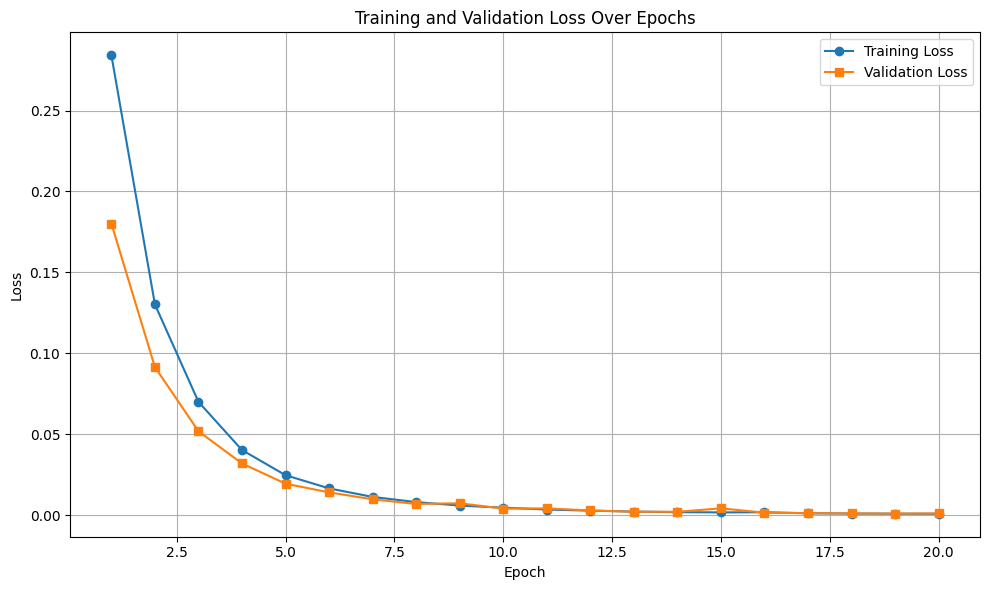

In [29]:
import matplotlib.pyplot as plt
import pandas as pd

# Path to CSV
csv_path = os.path.join(base_dir, "models", "losses.csv")

# Load CSV
loss_df = pd.read_csv(csv_path)

# Plot
plt.figure(figsize=(10, 6))
plt.plot(loss_df['epoch'], loss_df['train_loss'], label='Training Loss', marker='o')
plt.plot(loss_df['epoch'], loss_df['val_loss'], label='Validation Loss', marker='s')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [123]:
import math
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from skimage import measure
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

# Enable inline plotting in Jupyter
%matplotlib inline

In [124]:
# Define Binary U-Net
class UNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1):
        super(UNet, self).__init__()
        def CBR(in_ch, out_ch):
            return nn.Sequential(
                nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_ch),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_ch),
                nn.ReLU(inplace=True)
            )
        self.enc1 = CBR(in_channels, 64)
        self.pool1 = nn.MaxPool2d(2)
        self.enc2 = CBR(64, 128)
        self.pool2 = nn.MaxPool2d(2)
        self.enc3 = CBR(128, 256)
        self.pool3 = nn.MaxPool2d(2)
        self.enc4 = CBR(256, 512)
        self.pool4 = nn.MaxPool2d(2)
        self.bottleneck = CBR(512, 1024)
        self.up4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.dec4 = CBR(1024, 512)
        self.up3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dec3 = CBR(512, 256)
        self.up2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec2 = CBR(256, 128)
        self.up1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec1 = CBR(128, 64)
        self.final_conv = nn.Conv2d(64, out_channels, kernel_size=1)

    def center_crop(self, enc_feat, target_feat):
        _, _, h, w = enc_feat.shape
        _, _, th, tw = target_feat.shape
        dh = (h - th) // 2
        dw = (w - tw) // 2
        return enc_feat[:, :, dh:dh+th, dw:dw+tw]

    def forward(self, x):
        enc1 = self.enc1(x)
        e2 = self.pool1(enc1)
        enc2 = self.enc2(e2)
        e3 = self.pool2(enc2)
        enc3 = self.enc3(e3)
        e4 = self.pool3(enc3)
        enc4 = self.enc4(e4)
        e5 = self.pool4(enc4)
        bot = self.bottleneck(e5)
        d4 = self.up4(bot)
        enc4_crop = self.center_crop(enc4, d4)
        d4 = torch.cat([d4, enc4_crop], dim=1)
        d4 = self.dec4(d4)
        d3 = self.up3(d4)
        enc3_crop = self.center_crop(enc3, d3)
        d3 = torch.cat([d3, enc3_crop], dim=1)
        d3 = self.dec3(d3)
        d2 = self.up2(d3)
        enc2_crop = self.center_crop(enc2, d2)
        d2 = torch.cat([d2, enc2_crop], dim=1)
        d2 = self.dec2(d2)
        d1 = self.up1(d2)
        enc1_crop = self.center_crop(enc1, d1)
        d1 = torch.cat([d1, enc1_crop], dim=1)
        d1 = self.dec1(d1)
        return self.final_conv(d1)


In [125]:
# Model Loading & Padded Inference

def load_model(model_path, device='cuda'):
    """Load binary U-Net model from disk."""
    model = UNet(in_channels=1, out_channels=1)
    state = torch.load(model_path, map_location=device)
    model.load_state_dict(state)
    model.to(device).eval()
    return model


def infer_volume(model, volume_path, device='cuda', window=(-200,300)):
    """
    Perform padded inference to avoid broadcast errors.
    Returns a 3D mask same size as input volume.
    """
    img_nii = nib.load(volume_path)
    vol = img_nii.get_fdata().astype(np.float32)
    vol = np.clip((vol - window[0])/(window[1]-window[0]), 0, 1)
    S, H, W = vol.shape

    # Compute padded dimensions (multiple of 16)
    Hp = math.ceil(H/16)*16
    Wp = math.ceil(W/16)*16

    pred_vol = np.zeros((S, H, W), dtype=np.uint8)

    for i in range(S):
        slice_img = vol[i]
        pad_h = Hp - H
        pad_w = Wp - W
        inp_np = np.pad(slice_img, ((0,pad_h),(0,pad_w)), mode='constant')
        inp = torch.from_numpy(inp_np[None,None]).to(device)
        with torch.no_grad():
            out = model(inp)
            mask_full = (torch.sigmoid(out) > 0.5).cpu().numpy()[0,0]
        pred_vol[i] = mask_full[:H, :W].astype(np.uint8)

    return pred_vol, img_nii.affine


In [126]:
# Visualization Helpers

def overlay_slice(original, mask, color=(1,0,0), alpha=0.4):
    """Overlay binary mask on grayscale slice."""
    fig, ax = plt.subplots(1,1, figsize=(5,5))
    ax.imshow(original, cmap='gray')
    ax.imshow(mask, cmap='Reds', alpha=alpha)
    ax.axis('off')
    plt.show()

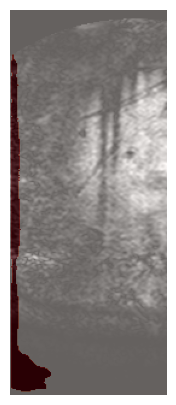

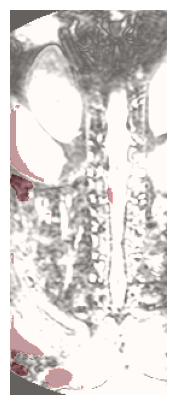

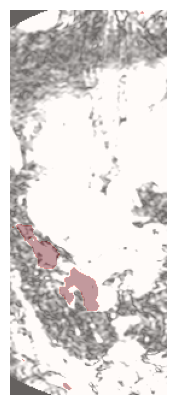

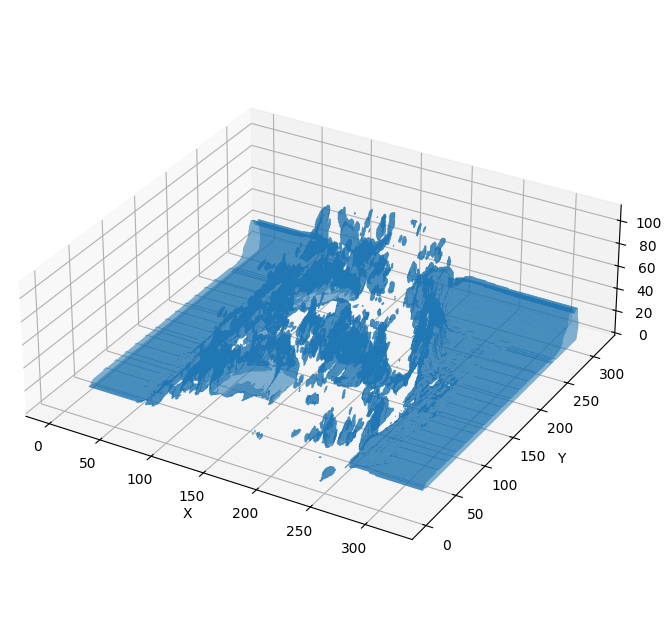

In [127]:
# Example Execution & Visualization

# 1) Set paths & device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model_path = "E:/3D_Organs/data_preprocessed/Task02_Heart/models/unet_task02_heart_best.pth"
volume_path = "E:/3D_Organs/data_preprocessed/Task02_Heart/imagesTr/la_003.nii.gz"

# 2) Load model & volume inference
model = load_model(model_path, device)
pred_mask, affine = infer_volume(model, volume_path, device)

# 3) Show sample 2D overlays
indices = [50, 100, 150]
# reload raw data for display
window = (-200, 300)
raw_vol = nib.load(volume_path).get_fdata().astype(np.float32)
raw_vol = np.clip((raw_vol - window[0]) / (window[1] - window[0]), 0, 1)
for idx in indices:
    overlay_slice(raw_vol[idx], pred_mask[idx])

# 4) Render 3D mesh
verts, faces, normals, values = measure.marching_cubes(pred_mask, level=0.5)
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
mesh = Poly3DCollection(verts[faces], alpha=0.7)
ax.add_collection3d(mesh)
ax.set_box_aspect([np.ptp(verts[:,0]), np.ptp(verts[:,1]), np.ptp(verts[:,2])])
ax.set_xlabel('X'); ax.set_ylabel('Y'); ax.set_zlabel('Z')
plt.show()

In [128]:
import os
import glob
import torch
import torch.nn as nn
import numpy as np
import SimpleITK as sitk
from scipy import ndimage
from tqdm import tqdm

# UNet Model Definition
class UNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1):
        super(UNet, self).__init__()
        def CBR(in_ch, out_ch):
            return nn.Sequential(
                nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_ch),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_ch),
                nn.ReLU(inplace=True)
            )
        self.enc1 = CBR(in_channels, 64)
        self.pool1 = nn.MaxPool2d(2)
        self.enc2 = CBR(64, 128)
        self.pool2 = nn.MaxPool2d(2)
        self.enc3 = CBR(128, 256)
        self.pool3 = nn.MaxPool2d(2)
        self.enc4 = CBR(256, 512)
        self.pool4 = nn.MaxPool2d(2)
        self.bottleneck = CBR(512, 1024)
        self.up4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.dec4 = CBR(1024, 512)
        self.up3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dec3 = CBR(512, 256)
        self.up2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec2 = CBR(256, 128)
        self.up1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec1 = CBR(128, 64)
        self.final_conv = nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, x):
        enc1 = self.enc1(x)
        e2 = self.pool1(enc1)
        enc2 = self.enc2(e2)
        e3 = self.pool2(enc2)
        enc3 = self.enc3(e3)
        e4 = self.pool3(enc3)
        enc4 = self.enc4(e4)
        e5 = self.pool4(enc4)
        bot = self.bottleneck(e5)
        d4 = self.up4(bot)
        d4 = torch.cat([d4, enc4], dim=1)
        d4 = self.dec4(d4)
        d3 = self.up3(d4)
        d3 = torch.cat([d3, enc3], dim=1)
        d3 = self.dec3(d3)
        d2 = self.up2(d3)
        d2 = torch.cat([d2, enc2], dim=1)
        d2 = self.dec2(d2)
        d1 = self.up1(d2)
        d1 = torch.cat([d1, enc1], dim=1)
        d1 = self.dec1(d1)
        return self.final_conv(d1)


In [129]:
def normalize_ct(arr, hu_min=-100, hu_max=400):
    arr = np.clip(arr, hu_min, hu_max)
    arr = (arr - hu_min) / (hu_max - hu_min)
    return arr.astype(np.float32)

def postprocess_mask(mask):
    labeled, num = ndimage.label(mask)
    sizes = ndimage.sum(mask, labeled, range(1, num+1))
    threshold = 0.01 * mask.sum()
    clean = np.zeros_like(mask)
    for i, sz in enumerate(sizes, start=1):
        if sz >= threshold:
            clean[labeled == i] = 1
    clean = ndimage.binary_closing(clean, structure=np.ones((3,3,3))).astype(np.uint8)
    return clean

def infer_on_volume(ct_nifti_path, model, device, output_mask_nifti, threshold=0.5):
    img_ct = sitk.ReadImage(ct_nifti_path)
    arr_ct = sitk.GetArrayFromImage(img_ct).astype(np.float32)
    arr_norm = normalize_ct(arr_ct)

    Z, Y, X = arr_norm.shape
    pred_vol = np.zeros((Z, Y, X), dtype=np.uint8)

    for z in range(Z):
        slice_img = arr_norm[z]
        slice_tensor = torch.from_numpy(slice_img).unsqueeze(0).unsqueeze(0).to(device)
        with torch.no_grad():
            logits = model(slice_tensor)
            prob = torch.sigmoid(logits).cpu().numpy()[0, 0]
        pred_vol[z] = (prob > threshold).astype(np.uint8)

    pred_clean = postprocess_mask(pred_vol)
    mask_img = sitk.GetImageFromArray(pred_clean)
    mask_img.CopyInformation(img_ct)
    os.makedirs(os.path.dirname(output_mask_nifti), exist_ok=True)
    sitk.WriteImage(mask_img, output_mask_nifti)
    print(f"✅ Saved: {output_mask_nifti}")


In [130]:
# Set paths
ct_folder = "E:/3D_Organs/data_preprocessed/Task02_Heart/imagesTs"
checkpoint = "E:/3D_Organs/data_preprocessed/Task02_Heart/models/unet_task02_heart_best.pth"
output_dir = "outputs/preds"

# Load model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet().to(device)
model.load_state_dict(torch.load(checkpoint, map_location=device))
model.eval()


UNet(
  (enc1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (enc2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False

In [131]:
os.makedirs(output_dir, exist_ok=True)
nii_files = glob.glob(os.path.join(ct_folder, "*.nii.gz"))

print(f"🔍 Found {len(nii_files)} files.")
for ct_path in nii_files:
    base_name = os.path.basename(ct_path).replace(".nii.gz", "_pred.nii.gz")
    out_mask = os.path.join(output_dir, base_name)
    print(f"Processing {base_name}...")
    infer_on_volume(ct_path, model, device, out_mask)

print("🎉 All volumes processed successfully!")


🔍 Found 10 files.
Processing la_015_pred.nii.gz...
✅ Saved: outputs/preds\la_015_pred.nii.gz
Processing la_025_pred.nii.gz...
✅ Saved: outputs/preds\la_025_pred.nii.gz
Processing la_013_pred.nii.gz...
✅ Saved: outputs/preds\la_013_pred.nii.gz
Processing la_001_pred.nii.gz...
✅ Saved: outputs/preds\la_001_pred.nii.gz
Processing la_027_pred.nii.gz...
✅ Saved: outputs/preds\la_027_pred.nii.gz
Processing la_006_pred.nii.gz...
✅ Saved: outputs/preds\la_006_pred.nii.gz
Processing la_008_pred.nii.gz...
✅ Saved: outputs/preds\la_008_pred.nii.gz
Processing la_012_pred.nii.gz...
✅ Saved: outputs/preds\la_012_pred.nii.gz
Processing la_028_pred.nii.gz...
✅ Saved: outputs/preds\la_028_pred.nii.gz
Processing la_002_pred.nii.gz...
✅ Saved: outputs/preds\la_002_pred.nii.gz
🎉 All volumes processed successfully!


In [5]:
# Cell 1: Decimation helper and Open3D check
import numpy as np
import trimesh

try:
    import open3d as o3d
    _HAS_O3D = True
    print("✅ Open3D available: decimation enabled.")
except ImportError:
    print("⚠️ Open3D not available: decimation will be skipped.")
    _HAS_O3D = False

def simplify_with_open3d(mesh: trimesh.Trimesh, target_face_count: int) -> trimesh.Trimesh:
    """
    If Open3D is available, quadric‐decimate mesh down to target_face_count and return new Trimesh.
    Otherwise returns the original mesh.
    """
    if not _HAS_O3D or target_face_count is None:
        return mesh

    o3d_mesh = o3d.geometry.TriangleMesh(
        vertices=o3d.utility.Vector3dVector(mesh.vertices),
        triangles=o3d.utility.Vector3iVector(mesh.faces)
    )
    o3d_mesh.compute_vertex_normals()
    dec = o3d_mesh.simplify_quadric_decimation(target_face_count)
    dec.remove_degenerate_triangles()
    dec.remove_duplicated_triangles()
    dec.remove_duplicated_vertices()
    dec.remove_non_manifold_edges()

    verts   = np.asarray(dec.vertices)
    faces   = np.asarray(dec.triangles)
    normals = np.asarray(dec.vertex_normals)
    return trimesh.Trimesh(vertices=verts, faces=faces, vertex_normals=normals, process=False)


✅ Open3D available: decimation enabled.


In [6]:
# Cell 2: NIfTI I/O, surface extraction, and mask→STL function
import os
import SimpleITK as sitk
from skimage import measure
import trimesh

def mask_to_stl(mask_nifti_path: str,
                reference_nifti_path: str,
                output_stl_path: str,
                iso_level: float = 0.5,
                target_face_count: int = None):
    # 1. Load mask array
    mask_img = sitk.ReadImage(mask_nifti_path)
    mask_arr = sitk.GetArrayFromImage(mask_img).astype(np.uint8)

    # 2. Get voxel spacing
    ref = sitk.ReadImage(reference_nifti_path)
    sx, sy, sz = ref.GetSpacing()
    spacing_mc = (sz, sy, sx)  # for marching_cubes: (z, y, x)

    # 3. Marching cubes
    print(f"🔍 Running marching_cubes on '{os.path.basename(mask_nifti_path)}' …")
    verts, faces, normals, _ = measure.marching_cubes(mask_arr,
                                                      level=iso_level,
                                                      spacing=spacing_mc)
    print(f"   • Extracted {len(verts):,} verts, {len(faces):,} faces")

    # 4. Build mesh and clean
    mesh = trimesh.Trimesh(vertices=verts, faces=faces, vertex_normals=normals, process=False)
    mesh.remove_duplicate_faces()
    mesh.remove_unreferenced_vertices()
    mesh.fill_holes()

    # 5. Optional decimation
    if target_face_count is not None and len(mesh.faces) > target_face_count:
        print(f"🛠️ Decimating to {target_face_count:,} faces …")
        mesh = simplify_with_open3d(mesh, target_face_count)
        print(f"   • Now {len(mesh.faces):,} faces")

    # 6. Ensure watertight
    if not mesh.is_watertight:
        print("⚠️ Not watertight; filling holes again …")
        mesh.fill_holes()

    # 7. Export STL
    os.makedirs(os.path.dirname(output_stl_path), exist_ok=True)
    mesh.export(output_stl_path)
    print(f"✅ Saved STL: '{output_stl_path}'")


In [7]:
# Cell 3: Single-file example
mask_nifti   = 'outputs/preds/la_002_pred.nii.gz'
reference_ct = 'data_preprocessed/Task02_Heart/imagesTs/la_002.nii.gz'
output_stl   = 'outputs/meshes/la_002.stl'

mask_to_stl(mask_nifti, reference_ct, output_stl,
            iso_level=0.5, target_face_count=200_000)


🔍 Running marching_cubes on 'la_002_pred.nii.gz' …
   • Extracted 36,019 verts, 72,046 faces
✅ Saved STL: 'outputs/meshes/la_002.stl'


C:\Users\ADITYA\AppData\Local\Temp\ipykernel_24516\2466458430.py:30: DeprecationWarning: `remove_duplicate_faces` is deprecated and will be removed in March 2024: replace with `mesh.update_faces(mesh.unique_faces())`
  mesh.remove_duplicate_faces()


In [8]:
# Cell 4: Batch conversion from test_list.txt
test_list_path = 'data_preprocessed/Task02_Heart/test_list.txt'
os.makedirs('outputs/meshes', exist_ok=True)

with open(test_list_path, 'r') as f:
    for ct_path in f:
        ct_path = ct_path.strip()
        base    = os.path.splitext(os.path.basename(ct_path))[0].replace('.nii','')
        mask_p  = f"outputs/preds/{base}_pred.nii.gz"
        stl_out = f"outputs/meshes/{base}.stl"
        mask_to_stl(mask_p, ct_path, stl_out,
                    iso_level=0.5, target_face_count=200_000)


🔍 Running marching_cubes on 'la_015_pred.nii.gz' …
   • Extracted 41,278 verts, 82,596 faces


C:\Users\ADITYA\AppData\Local\Temp\ipykernel_24516\2466458430.py:30: DeprecationWarning: `remove_duplicate_faces` is deprecated and will be removed in March 2024: replace with `mesh.update_faces(mesh.unique_faces())`
  mesh.remove_duplicate_faces()


✅ Saved STL: 'outputs/meshes/la_015.stl'
🔍 Running marching_cubes on 'la_025_pred.nii.gz' …
   • Extracted 42,487 verts, 84,934 faces
✅ Saved STL: 'outputs/meshes/la_025.stl'
🔍 Running marching_cubes on 'la_013_pred.nii.gz' …
   • Extracted 38,421 verts, 76,878 faces
✅ Saved STL: 'outputs/meshes/la_013.stl'
🔍 Running marching_cubes on 'la_001_pred.nii.gz' …
   • Extracted 104,071 verts, 208,162 faces
🛠️ Decimating to 200,000 faces …
   • Now 200,000 faces
✅ Saved STL: 'outputs/meshes/la_001.stl'
🔍 Running marching_cubes on 'la_027_pred.nii.gz' …
   • Extracted 62,669 verts, 125,362 faces
✅ Saved STL: 'outputs/meshes/la_027.stl'
🔍 Running marching_cubes on 'la_006_pred.nii.gz' …
   • Extracted 60,839 verts, 121,670 faces
✅ Saved STL: 'outputs/meshes/la_006.stl'
🔍 Running marching_cubes on 'la_008_pred.nii.gz' …
   • Extracted 43,968 verts, 87,980 faces
✅ Saved STL: 'outputs/meshes/la_008.stl'
🔍 Running marching_cubes on 'la_012_pred.nii.gz' …
   • Extracted 49,797 verts, 99,566 faces
✅ 

In [20]:
#MODIFIED CODE
"Preprocessing Volume"
def preprocess_volume(input_path, output_path, new_spacing=(0.5,0.5,0.5)):
    img = sitk.ReadImage(input_path)
    original_size = np.array(img.GetSize(), dtype=int)
    original_spacing = np.array(img.GetSpacing())
    new_size = np.round(original_size * (original_spacing / new_spacing)).astype(int)

    resampler = sitk.ResampleImageFilter()
    resampler.SetOutputSpacing(new_spacing)
    resampler.SetSize([int(s) for s in new_size])
    resampler.SetInterpolator(sitk.sitkLinear)
    img_resampled = resampler.Execute(img)

    img_denoised = sitk.CurvatureFlow(image1=img_resampled,
                                       timeStep=0.125,
                                       numberOfIterations=5)

    arr = sitk.GetArrayFromImage(img_denoised).astype(np.float32)
    arr = (arr - arr.mean()) / arr.std()
    img_norm = sitk.GetImageFromArray(arr)
    img_norm.CopyInformation(img_denoised)
    sitk.WriteImage(img_norm, output_path)
    return output_path


In [21]:
# Mask Cleanup
def clean_mask(mask_path, cleaned_path):
    mask = sitk.ReadImage(mask_path) > 0
    arr = sitk.GetArrayFromImage(mask).astype(np.uint8)

    labels = measure.label(arr, connectivity=3)
    props = measure.regionprops(labels)
    largest_label = max(props, key=lambda x: x.area).label
    arr_clean = (labels == largest_label).astype(np.uint8)

    arr_closed = morphology.closing(arr_clean, morphology.ball(2))
    mask_cleaned = sitk.GetImageFromArray(arr_closed)
    mask_cleaned.CopyInformation(mask)
    sitk.WriteImage(mask_cleaned, cleaned_path)
    return cleaned_path


In [22]:
# Mask Smoothing
def smooth_mask(cleaned_path, smooth_path_p):
    mask = sitk.ReadImage(cleaned_path)
    smoothed = sitk.CurvatureFlow(image1=mask,
                                  timeStep=0.125,
                                  numberOfIterations=10)
    sitk.WriteImage(smoothed, smooth_path_p)
    return smooth_path_p


In [24]:
# Mesh Extraction
def mask_to_mesh(smooth_path, mesh_path, spacing=(0.5,0.5,0.5)):
    mask = sitk.ReadImage(smooth_path) > 0
    arr = sitk.GetArrayFromImage(mask).astype(np.uint8)
    verts, faces, normals, _ = measure.marching_cubes(arr, level=0.5, spacing=spacing)

    mesh = trimesh.Trimesh(vertices=verts, faces=faces, vertex_normals=normals)
    mesh = mesh.smoothed(filter='laplacian', iterations=50)
    mesh.export(mesh_path)
    return mesh_path


In [ ]:
# 3. Smooth the cleaned mask and debug it
sm_path = smooth_mask(cleaned_path, mesh_path)
sm_img  = sitk.ReadImage(sm_path)
sm_arr  = sitk.GetArrayFromImage(sm_img)
print("Unique values in smoothed mask:", np.unique(sm_arr))

# 4. If it’s non-empty, proceed to mesh extraction
if np.any(sm_arr):
    mask_to_mesh(sm_path, raw_mesh, spacing=(1.0,1.0,1.0))
else:
    raise RuntimeError("Smoothed mask is empty! Go back and adjust smoothing/threshold.")


In [14]:
# Mesh Repair & Remeshing
import trimesh
import open3d as o3d

def repair_and_remesh(mesh_path, final_stl_path, target_faces=100000):
    # Load with trimesh for repairs
    mesh = trimesh.load(mesh_path)
    mesh.fill_holes()
    mesh.remove_degenerate_faces()
    mesh.remove_unreferenced_vertices()
    mesh.export("tmp_no_decim.ply")

    # Load into Open3D for decimation
    o3d_mesh = o3d.io.read_triangle_mesh("tmp_no_decim.ply")
    o3d_mesh = o3d_mesh.simplify_quadric_decimation(target_faces)
    o3d.io.write_triangle_mesh(final_stl_path, o3d_mesh)

    return final_stl_path




In [15]:
if __name__ == "__main__":
    # Paths based on your MSD setup
    raw_ct       = "data_preprocessed/Task02_Heart/imagesTr/la_010.nii.gz"
    preproc_ct   = "data_preprocessed/Task02_Heart/imagesTr_norm/la_010_norm.nii.gz"
    
    # Your UNet model inference output (after running infer_unet.py)
    seg_mask     = "outputs/preds/la_001_pred.nii.gz"  
    
    # Intermediate & final paths
    clean_mask_p = "outputs/preds_clean/la_001_pred_clean.nii.gz"
    smooth_mask_p  = "outputs/preds_clean/la_001_pred_smooth.nii.gz"
    raw_mesh     = "outputs/meshes_raw/la_001_raw.ply"
    final_stl    = "outputs/meshes/la_001.stl"
    
    # Create folders if they don't exist
    os.makedirs("outputs/preds_clean", exist_ok=True)
    os.makedirs("outputs/meshes_raw", exist_ok=True)
    os.makedirs("outputs/meshes", exist_ok=True)

    # Preprocessing (you may skip if already normalized)
    # preprocess_volume(raw_ct, preproc_ct)  # Optional — already done with `ct_norm`

    # Cleaning & Mesh conversion steps
    clean_mask(seg_mask, clean_mask_p)
    smooth_mask(clean_mask_p, smooth_mask_p)
    mask_to_mesh(smooth_mask_p, raw_mesh, spacing=(1.0, 1.0, 1.0))  # CT spacing assumed 1mm³
    repair_and_remesh(raw_mesh, final_stl)

    print("✔ STL mesh ready for 3D printing:", final_stl)


C:\Users\ADITYA\AppData\Local\Temp\ipykernel_25920\3601754765.py:8: DeprecationWarning: `mesh.smoothed()` is deprecated and will be removed in March 2024: use `mesh.smooth_shaded` or `trimesh.graph.smooth_shade(mesh)`
  mesh = mesh.smoothed(filter='laplacian', iterations=50)
C:\Users\ADITYA\AppData\Local\Temp\ipykernel_25920\1753690610.py:9: DeprecationWarning: `remove_degenerate_faces` is deprecated and will be removed in March 2024 replace with `self.update_faces(self.nondegenerate_faces(height=height))`
  mesh.remove_degenerate_faces()


[Open3D WARNING] Write STL failed: compute normals first.
✔ STL mesh ready for 3D printing: outputs/meshes/la_001.stl
